In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import chip8_vec as vec
import chip8_vec_th as vec_th


plt.rcParams["figure.figsize"] = [20, 8]
sns.set_theme()

In [28]:
game = "games/pong_1p.ch8"
n_values = [2**i for i in range(18)]
max_cycles = 1_000

df = pd.DataFrame(
    columns=[
        "module",
        "n_emulators",
        "n_frames",
        "time",
        "effective_fps",
    ]
)

for module in ["vec", "pytorch"]:
    if module == "vec":
        main = vec.main
    elif module == "pytorch":
        main = vec_th.main

    for n_emulators in tqdm(n_values):
        dt = main(game, n_emulators=n_emulators, max_cycles=max_cycles)
        new_row = pd.DataFrame(
            [
                {
                    "module": module,
                    "n_emulators": n_emulators,
                    "n_frames": max_cycles // 8,
                    "time": dt,
                    "effective_fps": n_emulators * (max_cycles // 8) / dt,
                }
            ]
        )
        df = (
            new_row
            if df.empty
            else pd.concat([df, new_row], ignore_index=True)
        )
df

100%|██████████| 18/18 [00:32<00:00,  1.79s/it]


,module,n_emulators,n_frames,time,effective_fps
0,vec,1,125,0.123301,1.013777e+03
1,vec,2,125,0.127127,1.966538e+03
2,vec,4,125,0.125715,3.977254e+03
3,vec,8,125,0.126583,7.899972e+03
4,vec,16,125,0.132400,1.510573e+04
5,vec,32,125,0.130469,3.065863e+04
6,vec,64,125,0.132120,6.055114e+04
7,vec,128,125,0.135479,1.180999e+05
8,vec,256,125,0.145809,2.194646e+05
9,vec,512,125,0.166740,3.838303e+05


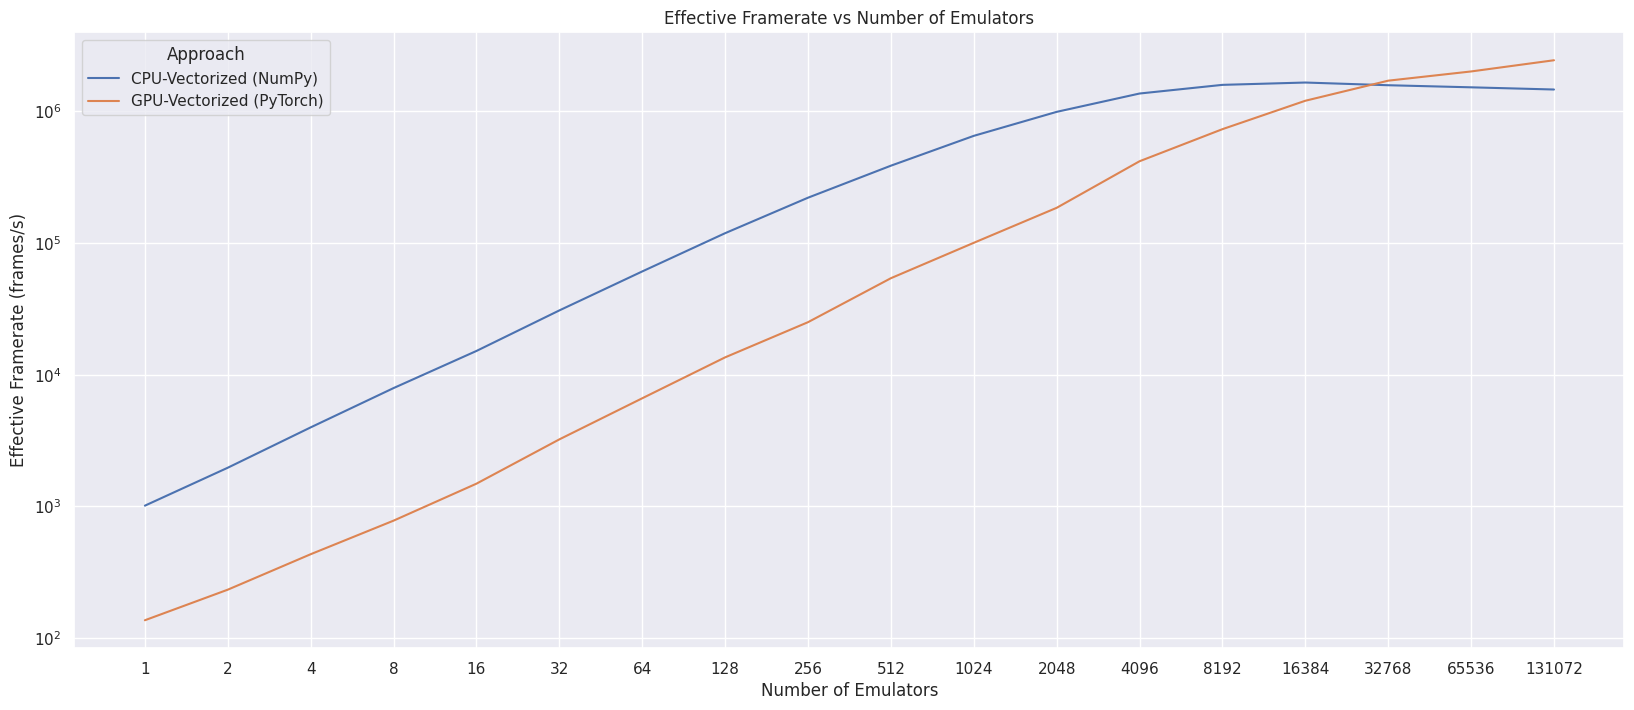

In [60]:
df["approach"] = df["module"].apply(
    lambda x: "CPU-Vectorized (NumPy)"
    if x == "vec"
    else "GPU-Vectorized (PyTorch)"
)

ax = sns.lineplot(data=df, x="n_emulators", y="effective_fps", hue="approach")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(n_values)
ax.set_xticklabels(n_values)
ax.legend(title="Approach", loc="upper left")

plt.xlabel("Number of Emulators")
plt.ylabel("Effective Framerate (frames/s)")
plt.title("Effective Framerate vs Number of Emulators")
plt.show()

# TESTAR ESSES NÚMEROS COM GPU NO FORMATO ANTIGO!